# AMSC698K Homework 7
##### Elijah Kin & Noorain Noorani

In [1]:
import numpy as np
import os
import sys

from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
#later: qiskit_nature.settings.use_pauli_sum_op = False
from qiskit.circuit.library import EfficientSU2
from qiskit_aer.primitives import Estimator
import matplotlib.pyplot as plt

# list of supported optimizers ...
import qiskit_algorithms
#dir(qiskit_algorithms.optimizers)
from qiskit_algorithms.optimizers import SPSA, SLSQP, COBYLA

## optional suppression of deprecation warnings: often in qiskit 
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=UserWarning)

### Plot the dissociation profile obtained via VQE and exact solver for the H2 and LiH molecules. Suggested distance ranges for H2: 0.25 to 3.0 Å, for LiH: 0.5 to 4.0 Å. 

In [2]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

### H2

In [3]:
def get_H2_qubit_operator(dist):
    # define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    driver = PySCFDriver.from_molecule(molecule)
    # get properties
    properties = driver.run()
    # create a reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True,remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [4]:
distances = np.arange(0.25, 3.0, 0.25)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(run_options={'shots':1000})
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, 
                             problem, mapper) = get_H2_qubit_operator( dist )
    result = exact_solver( qubit_op, problem )
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock( num_spatial_orbitals, num_particles, mapper )
    var_form = UCCSD( num_spatial_orbitals, num_particles, 
                     mapper, initial_state=init_state )
    vqe = VQE( noiseless_estimator, var_form,
               optimizer, initial_point=[0] * var_form.num_parameters,)
    vqe_calc = vqe.compute_minimum_eigenvalue( qubit_op )
    vqe_result = problem.interpret( vqe_calc ).total_energies[0].real
    vqe_energies.append(vqe_result)
    # Get the optimal parameters from the VQE calculation result
    print( f"Interatomic Distance: {np.round(dist, 2)}",
            f"VQE Result: {vqe_result:.5f}",
            f"Exact Energy: {exact_energies[-1]:.5f}" )

optimal_parameters = vqe_calc.optimal_point

# update QuantumCircuit with the optimal parameters
vqe.ansatz.assign_parameters( optimal_parameters, inplace=True )

optimal_parameters

Interatomic Distance: 0.25 VQE Result: 0.57525 Exact Energy: -0.31227
Interatomic Distance: 0.5 VQE Result: 0.05996 Exact Energy: -1.05516
Interatomic Distance: 0.75 VQE Result: -0.47986 Exact Energy: -1.13712
Interatomic Distance: 1.0 VQE Result: -0.43066 Exact Energy: -1.10115
Interatomic Distance: 1.25 VQE Result: -0.62889 Exact Energy: -1.04578
Interatomic Distance: 1.5 VQE Result: -0.65654 Exact Energy: -0.99815
Interatomic Distance: 1.75 VQE Result: -0.78367 Exact Energy: -0.96633
Interatomic Distance: 2.0 VQE Result: -0.42693 Exact Energy: -0.94864
Interatomic Distance: 2.25 VQE Result: -0.48777 Exact Energy: -0.93998
Interatomic Distance: 2.5 VQE Result: -0.37585 Exact Energy: -0.93605
Interatomic Distance: 2.75 VQE Result: -0.56319 Exact Energy: -0.93435


array([ 13009.55305834, -24754.56439657, -12631.54794258])

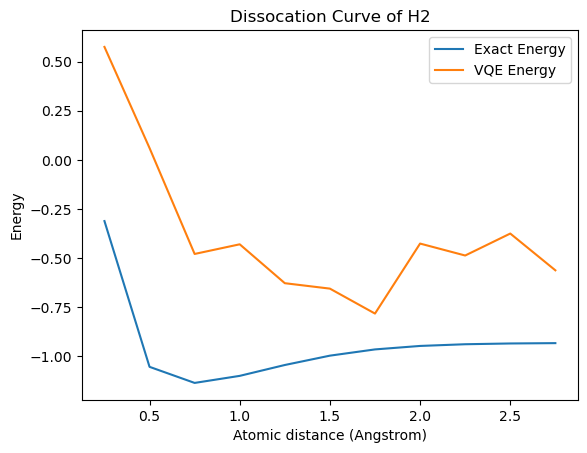

In [5]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.title("Dissocation Curve of H2")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

#### LiH

In [6]:
def get_LiH_qubit_operator(dist):
    # define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    driver = PySCFDriver.from_molecule(molecule)
    # get properties
    properties = driver.run()
    # create a reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True,remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [7]:
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(run_options={'shots':1000})
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, 
                             problem, mapper) = get_LiH_qubit_operator( dist )
    result = exact_solver( qubit_op, problem )
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock( num_spatial_orbitals, num_particles, mapper )
    var_form = UCCSD( num_spatial_orbitals, num_particles, 
                     mapper, initial_state=init_state )
    vqe = VQE( noiseless_estimator, var_form,
               optimizer, initial_point=[0] * var_form.num_parameters,)
    vqe_calc = vqe.compute_minimum_eigenvalue( qubit_op )
    vqe_result = problem.interpret( vqe_calc ).total_energies[0].real
    vqe_energies.append(vqe_result)
    # Get the optimal parameters from the VQE calculation result
    print( f"Interatomic Distance: {np.round(dist, 2)}",
            f"VQE Result: {vqe_result:.5f}",
            f"Exact Energy: {exact_energies[-1]:.5f}" )

optimal_parameters = vqe_calc.optimal_point

# update QuantumCircuit with the optimal parameters
vqe.ansatz.assign_parameters( optimal_parameters, inplace=True )

optimal_parameters

KeyboardInterrupt: 

In [ ]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.title("Dissocation Curve of LiH")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

### Obtain similar plots (energy vs. interatomic distance) for the s-orbitals considered in the STO-3G setting (1s-1s, 2s-2s).

##### Pennylane implementation

In [ ]:
from pennylane import numpy as np
import pennylane as qml

symbols = ["H", "H"]
# note: pennylane uses atomic units (Bohr radius), QISkit uses Angstroem!
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
molecule = qml.qchem.Molecule(symbols, coordinates)
H, qubits = qml.qchem.molecular_hamiltonian(molecule)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is  -0.04207255194743914 * I(0) + 0.1777135822909175 * Z(0) + 0.1777135822909175 * Z(1) + 0.17059759276836803 * (Z(0) @ Z(1)) + -0.2427450126094143 * Z(2) + 0.12293330449299361 * (Z(0) @ Z(2)) + 0.16768338855601356 * (Z(1) @ Z(2)) + 0.044750084063019925 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.044750084063019925 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.044750084063019925 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.044750084063019925 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.2427450126094143 * Z(3) + 0.16768338855601356 * (Z(0) @ Z(3)) + 0.12293330449299361 * (Z(1) @ Z(3)) + 0.1762766139418181 * (Z(2) @ Z(3))


In [ ]:
###!pip install jax==0.4.33

from jax import numpy as jnp
import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

dev = qml.device("lightning.qubit", wires=qubits)

electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

@qml.qnode(dev, interface="jax")
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=range(4))
    return qml.expval(H)

# define a cost function = expectation value obtained in function *circuit*
def cost_fn(param):
    return circuit(param, wires=range(qubits))

import optax 
opt = optax.sgd(learning_rate=0.4)

max_iterations = 100
conv_tol = 1e-06

theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

[1 1 0 0]
Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.2089
